# Russell 2000 Stock Skewness Analysis

Question: Are companies usually convex in their early stage and become concave as they grow larger?

This notebook downloads Russell 2000 stock price data from Yahoo Finance, calculates the skewness of log returns, and creates visualizations comparing skewness to ticker history and market cap.


In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


## 1. Load Russell 2000 Tickers and Download Stock Data


In [3]:
# Load Russell 2000 tickers from CSV
holdings_df = pd.read_csv('../data/IWM_holdings.csv')
tickers = holdings_df['Ticker'].tolist()
print(f"Total number of tickers: {len(tickers)}")


Total number of tickers: 2051


In [4]:
# # Download stock price data since 2000 and get market caps
# start_date = '2000-01-01'
# end_date = pd.Timestamp.now().strftime('%Y-%m-%d')

# # Initialize dictionaries to store data
# price_data = {}
# market_caps = {}
# failed_tickers = []

# # Download data for each ticker
# print("Downloading stock data...")
# for ticker in tqdm(tickers):
#     if ticker in price_data:
#         continue
#     try:
#         # Download stock data
#         stock = yf.Ticker(ticker)
#         hist = stock.history(start=start_date, end=end_date)
        
#         if len(hist) > 0:
#             price_data[ticker] = hist['Close']
            
#             # Get market cap
#             try:
#                 info = stock.info
#                 if 'marketCap' in info and info['marketCap'] is not None:
#                     market_caps[ticker] = info['marketCap']
#                 else:
#                     market_caps[ticker] = np.nan
#             except:
#                 market_caps[ticker] = np.nan
#         else:
#             failed_tickers.append(ticker)
#     except Exception as e:
#         failed_tickers.append(ticker)
        
# print(f"\nSuccessfully downloaded data for {len(price_data)} tickers")
# print(f"Failed to download data for {len(failed_tickers)} tickers")


In [5]:
# # Create DataFrame from price data
# price_df = pd.DataFrame(price_data)
# print(f"Price data shape: {price_df.shape}")

# # Save price data to CSV
# price_df.to_csv('../data/russell2000_prices.csv')
# print("Saved price data to data/russell2000_prices.csv")

# # Save market caps to CSV
# mcap_df = pd.DataFrame(list(market_caps.items()), columns=['Ticker', 'MarketCap'])
# mcap_df.to_csv('../data/russell2000_marketcaps.csv', index=False)
# print("Saved market cap data to data/russell2000_marketcaps.csv")


## 2. Load Data and Calculate Skewness of Log Returns


In [7]:
# Load price data and market caps
price_df = pd.read_csv('../data/russell2000_prices.csv', index_col=0, parse_dates=True)
price_df.index = pd.to_datetime(price_df.index, utc=True)
mcap_df = pd.read_csv('../data/russell2000_marketcaps.csv')

# Create a dictionary for easy market cap lookup
mcap_dict = dict(zip(mcap_df['Ticker'], mcap_df['MarketCap']))

print(f"Loaded price data shape: {price_df.shape}")
print(f"Loaded market cap data for {len(mcap_dict)} tickers")


Loaded price data shape: (6416, 1742)
Loaded market cap data for 1742 tickers


In [ ]:
# Calculate statistics for each ticker using normal inverse gaussian
results = []

print("Fitting normal inverse gaussians to log returns...")
for ticker in tqdm(price_df.columns[:]):  # Process all tickers
    prices = price_df[ticker].dropna()
    
    if len(prices) > 100:  # Need sufficient data for normal inverse gaussian fitting
        # Calculate log returns
        log_returns = np.log(prices / prices.shift(1)).dropna()
        
        if len(log_returns) > 100:  # Need sufficient returns for fitting
            try:
                params = stats.norminvgauss.fit(log_returns.values, method='mle')
                a, b, loc, scale = params

                mean, var, skew, kurt = stats.norminvgauss.stats(a, b, loc=loc, scale=scale, moments='mvsk')
                
                # Count non-NA days (ticker history)
                ticker_history = len(prices)
                
                # Get market cap
                market_cap = mcap_dict.get(ticker, np.nan)
                
                results.append({
                    'ticker': ticker,
                    'a': a,
                    'b': b,
                    'loc': loc,
                    'scale': scale,
                    'mean': mean,
                    'var': var,
                    'kurt': kurt,
                    'skewness': skew,
                    'ticker_history': ticker_history,
                    'market_cap': market_cap
                })
            except Exception as e:
                # Skip if fitting fails
                print(f"Failed to fit {ticker}: {str(e)}")
                continue

# Create results DataFrame
results_df = pd.DataFrame(results)

# Remove rows with NaN market cap for visualization
results_df = results_df.loc[
    (results_df['skewness'] < 100) & 
    (results_df['skewness'] > -100) &
    (results_df['b'] < 10) &
    (results_df['b'] > -10)
]
results_df = results_df.dropna(subset=['market_cap'])

print(f"\nCalculated statistics for {len(results_df)} tickers")
print(f"\nNormal inverse gaussian parameters summary:")
print(f"a - Mean: {results_df['a'].mean():.3f}, Median: {results_df['a'].median():.3f}")
print(f"b - Mean: {results_df['b'].mean():.3f}, Median: {results_df['b'].median():.3f}")


Fitting normal inverse gaussians to log returns...


100%|██████████| 1742/1742 [01:38<00:00, 17.69it/s]


Calculated statistics for 1736 tickers
After removing NaN market caps: 1736 tickers

Normal inverse gaussian parameters summary:
a - Mean: 1.504, Median: 0.458
b - Mean: 0.098, Median: 0.001


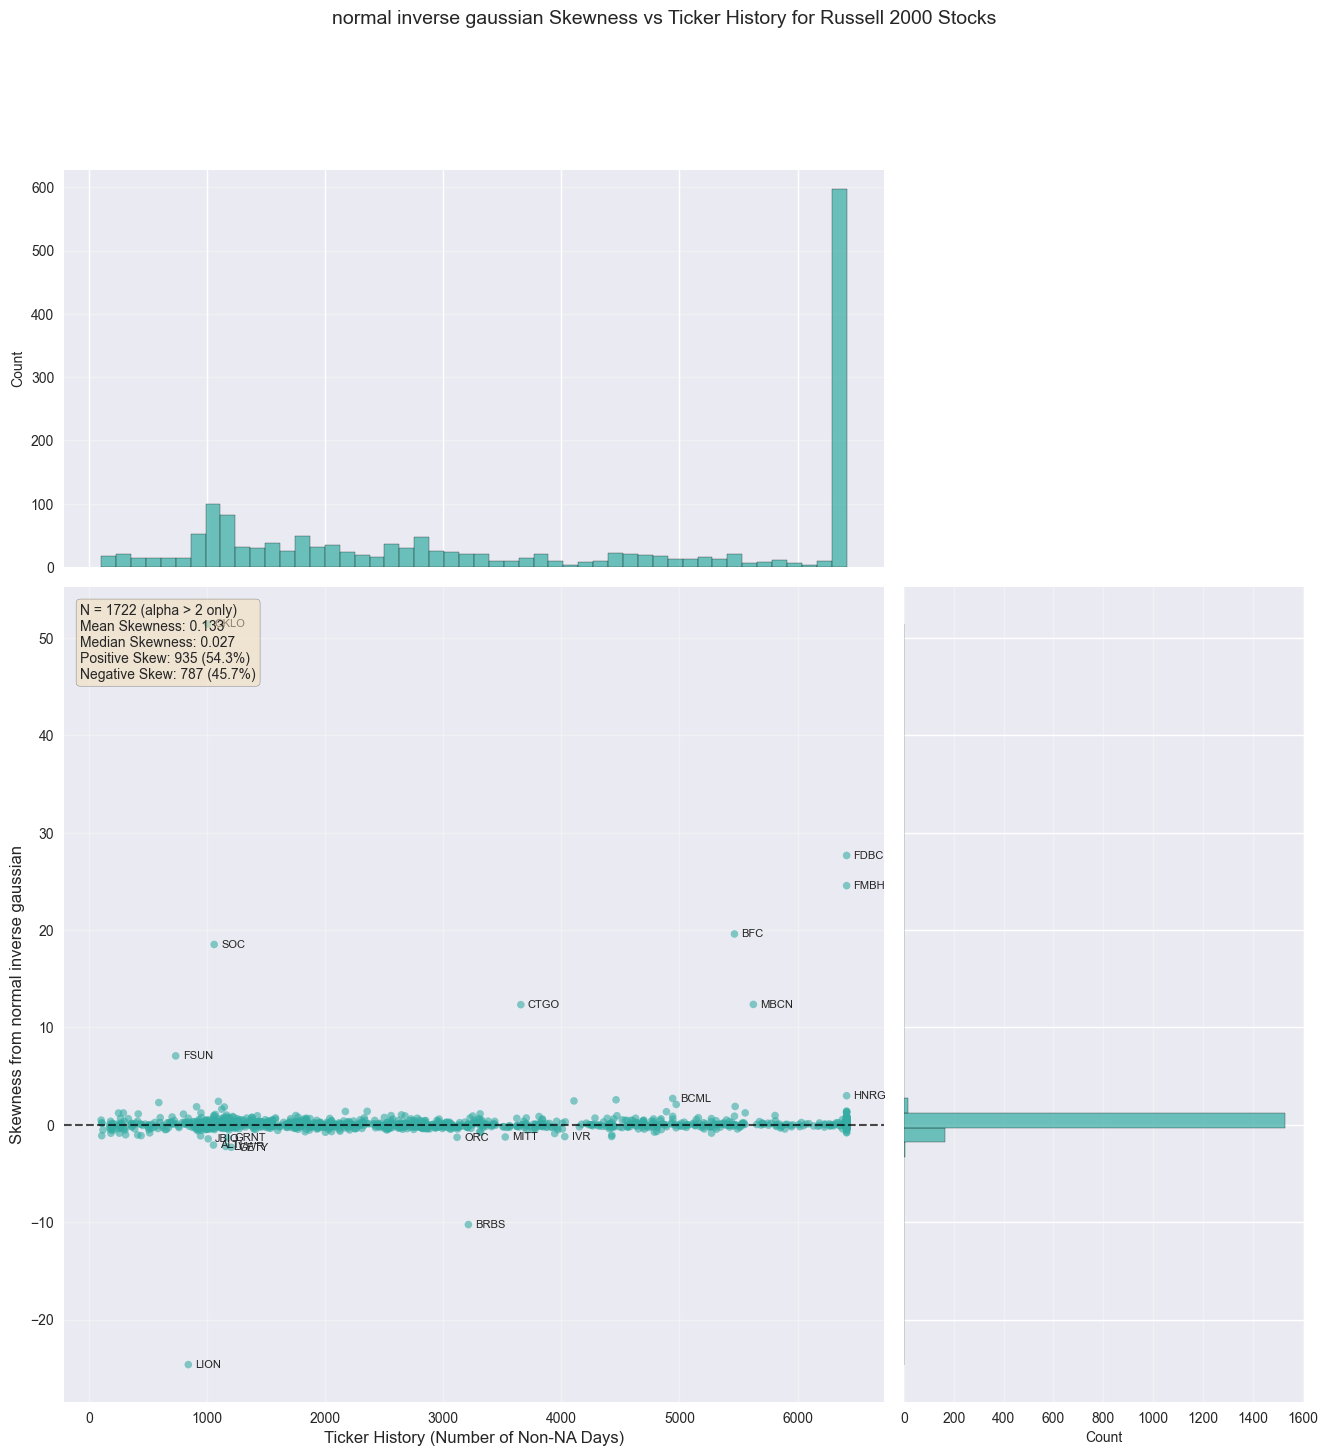

In [66]:
# Filter out rows where skewness couldn't be calculated (alpha <= 2)
results_df_skew = results_df.dropna(subset=['skewness'])

# Create figure with GridSpec
fig = plt.figure(figsize=(16, 16))
gs = fig.add_gridspec(3, 3, hspace=0.05, wspace=0.05)

# Main scatter plot
ax_main = fig.add_subplot(gs[1:, :-1])
ax_main.scatter(results_df_skew['ticker_history'], results_df_skew['skewness'], 
                alpha=0.6, s=30, c='C3', edgecolors='none')
ax_main.set_xlabel('Ticker History (Number of Non-NA Days)', fontsize=12)
ax_main.set_ylabel('Skewness from normal inverse gaussian', fontsize=12)
ax_main.grid(True, alpha=0.3)

# Add dashed black line at y=0
ax_main.axhline(y=0, color='black', linestyle='--', linewidth=1.5, alpha=0.7)

# Find top 10 and bottom 10 stocks by skewness
top_10 = results_df_skew.nlargest(10, 'skewness')
bottom_10 = results_df_skew.nsmallest(10, 'skewness')

# Add ticker labels for top 10 and bottom 10
for idx, row in top_10.iterrows():
    ax_main.annotate(row['ticker'], 
                     (row['ticker_history'], row['skewness']),
                     xytext=(5, 0), textcoords='offset points',
                     fontsize=8, ha='left', va='center')

for idx, row in bottom_10.iterrows():
    ax_main.annotate(row['ticker'], 
                     (row['ticker_history'], row['skewness']),
                     xytext=(5, 0), textcoords='offset points',
                     fontsize=8, ha='left', va='center')

# Top histogram for ticker history
ax_hist_x = fig.add_subplot(gs[0, :-1], sharex=ax_main)
ax_hist_x.hist(results_df_skew['ticker_history'], bins=50, alpha=0.7, color='C3', edgecolor='black')
ax_hist_x.set_ylabel('Count', fontsize=10)
ax_hist_x.tick_params(axis='x', labelbottom=False)
ax_hist_x.grid(True, alpha=0.3, axis='y')

# Right histogram for skewness
ax_hist_y = fig.add_subplot(gs[1:, -1], sharey=ax_main)
ax_hist_y.hist(results_df_skew['skewness'], bins=50, alpha=0.7, color='C3', 
               edgecolor='black', orientation='horizontal')
ax_hist_y.set_xlabel('Count', fontsize=10)
ax_hist_y.tick_params(axis='y', labelleft=False)
ax_hist_y.grid(True, alpha=0.3, axis='x')

# Add title
fig.suptitle('normal inverse gaussian Skewness vs Ticker History for Russell 2000 Stocks', fontsize=14, y=0.98)

# Calculate positive and negative skewness counts
positive_skew = (results_df_skew['skewness'] > 0).sum()
negative_skew = (results_df_skew['skewness'] < 0).sum()
zero_skew = (results_df_skew['skewness'] == 0).sum()
total = len(results_df_skew)

# Add statistics text with positive/negative counts
stats_text = f"N = {total} (alpha > 2 only)\n"
stats_text += f"Mean Skewness: {results_df_skew['skewness'].mean():.3f}\n"
stats_text += f"Median Skewness: {results_df_skew['skewness'].median():.3f}\n"
stats_text += f"Positive Skew: {positive_skew} ({positive_skew/total*100:.1f}%)\n"
stats_text += f"Negative Skew: {negative_skew} ({negative_skew/total*100:.1f}%)"
ax_main.text(0.02, 0.98, stats_text, transform=ax_main.transAxes, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()


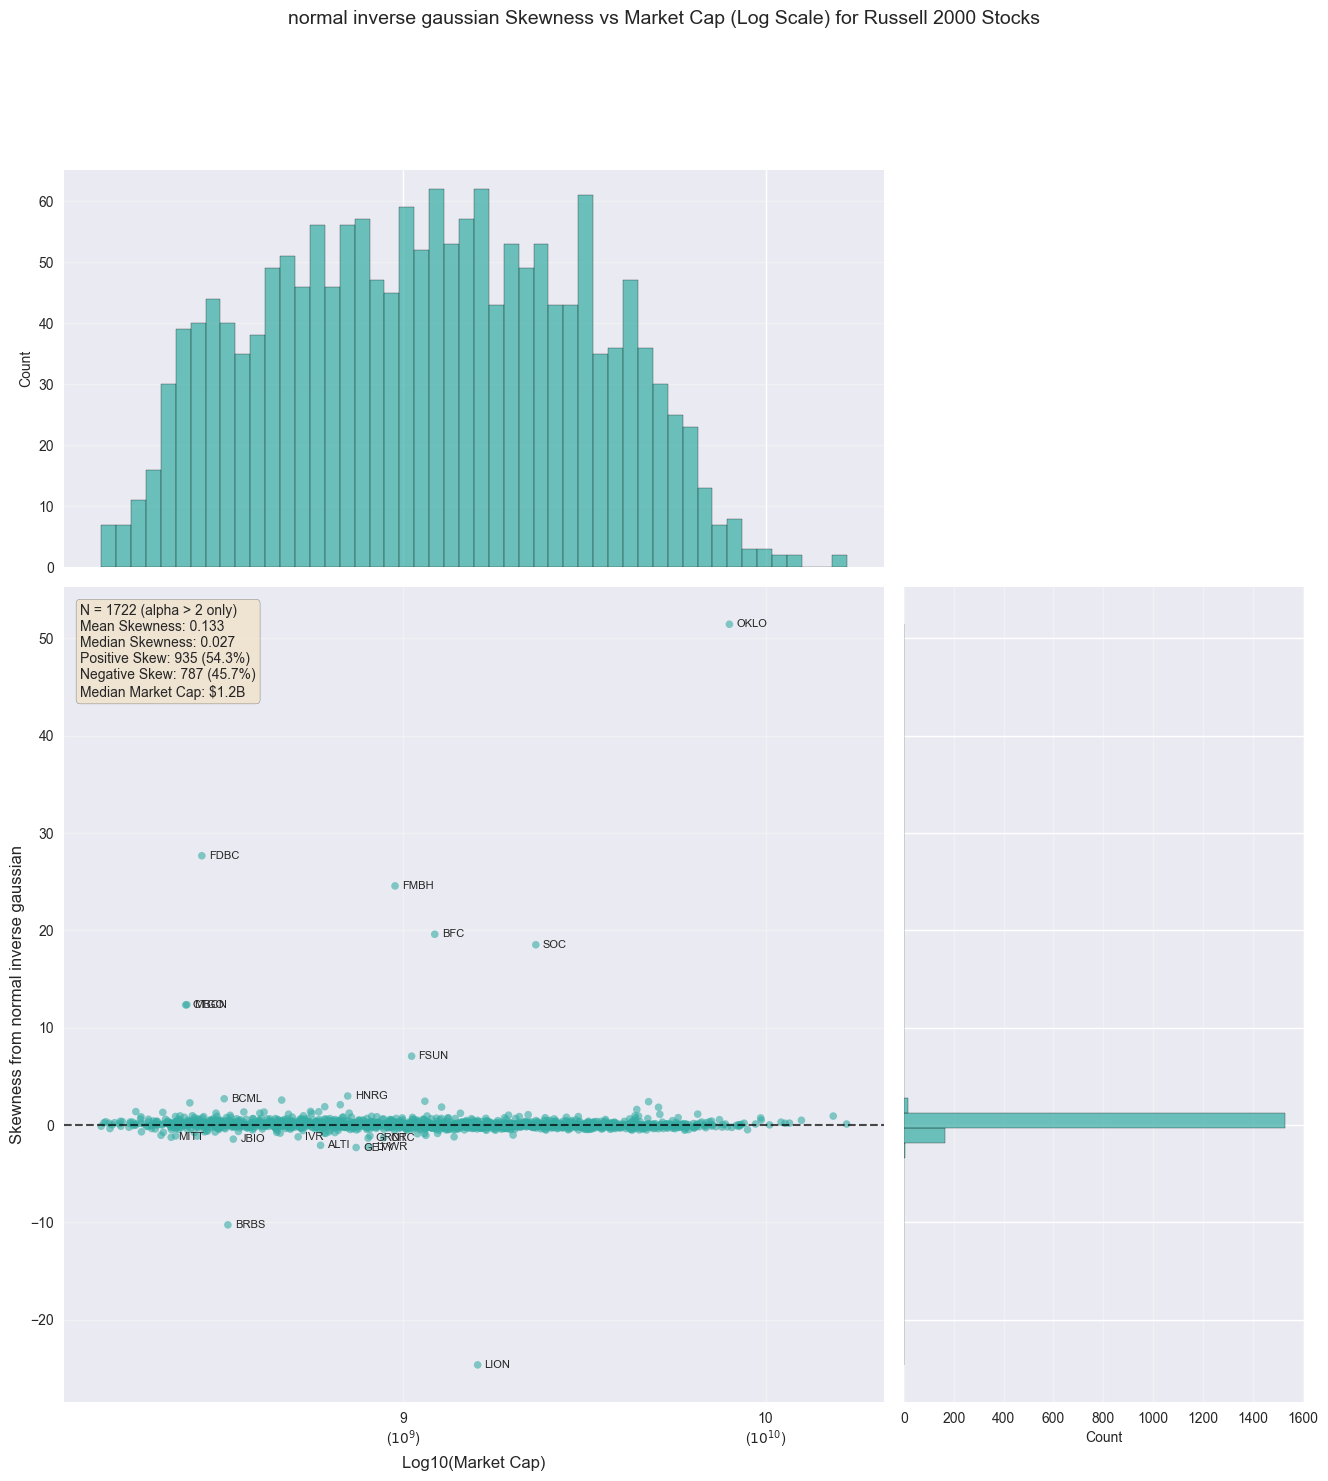

In [67]:
# Filter and add log market cap column
results_df_skew = results_df.dropna(subset=['skewness'])
results_df_skew['log_market_cap'] = np.log10(results_df_skew['market_cap'])

# Create figure with GridSpec
fig = plt.figure(figsize=(16, 16))
gs = fig.add_gridspec(3, 3, hspace=0.05, wspace=0.05)

# Main scatter plot
ax_main = fig.add_subplot(gs[1:, :-1])
ax_main.scatter(results_df_skew['log_market_cap'], results_df_skew['skewness'], 
                alpha=0.6, s=30, c='C3', edgecolors='none')
ax_main.set_xlabel('Log10(Market Cap)', fontsize=12)
ax_main.set_ylabel('Skewness from normal inverse gaussian', fontsize=12)
ax_main.grid(True, alpha=0.3)

# Add dashed black line at y=0
ax_main.axhline(y=0, color='black', linestyle='--', linewidth=1.5, alpha=0.7)

# Find top 10 and bottom 10 stocks by skewness
top_10_clean = results_df_skew.nlargest(10, 'skewness')
bottom_10_clean = results_df_skew.nsmallest(10, 'skewness')

# Add ticker labels for top 10 and bottom 10
for idx, row in top_10_clean.iterrows():
    ax_main.annotate(row['ticker'], 
                     (row['log_market_cap'], row['skewness']),
                     xytext=(5, 0), textcoords='offset points',
                     fontsize=8, ha='left', va='center')

for idx, row in bottom_10_clean.iterrows():
    ax_main.annotate(row['ticker'], 
                     (row['log_market_cap'], row['skewness']),
                     xytext=(5, 0), textcoords='offset points',
                     fontsize=8, ha='left', va='center')

# Format x-axis to show both log values and actual values
ax_main.set_xticks(np.arange(7, 12))
ax_main.set_xticklabels([f'{i}\n($10^{{{i}}}$)' for i in range(7, 12)])

# Top histogram for log market cap
ax_hist_x = fig.add_subplot(gs[0, :-1], sharex=ax_main)
ax_hist_x.hist(results_df_skew['log_market_cap'], bins=50, alpha=0.7, 
               color='C3', edgecolor='black')
ax_hist_x.set_ylabel('Count', fontsize=10)
ax_hist_x.tick_params(axis='x', labelbottom=False)
ax_hist_x.grid(True, alpha=0.3, axis='y')

# Right histogram for skewness
ax_hist_y = fig.add_subplot(gs[1:, -1], sharey=ax_main)
ax_hist_y.hist(results_df_skew['skewness'], bins=50, alpha=0.7, color='C3', 
               edgecolor='black', orientation='horizontal')
ax_hist_y.set_xlabel('Count', fontsize=10)
ax_hist_y.tick_params(axis='y', labelleft=False)
ax_hist_y.grid(True, alpha=0.3, axis='x')

# Add title
fig.suptitle('normal inverse gaussian Skewness vs Market Cap (Log Scale) for Russell 2000 Stocks', fontsize=14, y=0.98)

# Calculate positive and negative skewness counts
positive_skew_clean = (results_df_skew['skewness'] > 0).sum()
negative_skew_clean = (results_df_skew['skewness'] < 0).sum()
zero_skew_clean = (results_df_skew['skewness'] == 0).sum()
total_clean = len(results_df_skew)

# Add statistics text with positive/negative counts
stats_text = f"N = {total_clean} (alpha > 2 only)\n"
stats_text += f"Mean Skewness: {results_df_skew['skewness'].mean():.3f}\n"
stats_text += f"Median Skewness: {results_df_skew['skewness'].median():.3f}\n"
stats_text += f"Positive Skew: {positive_skew_clean} ({positive_skew_clean/total_clean*100:.1f}%)\n"
stats_text += f"Negative Skew: {negative_skew_clean} ({negative_skew_clean/total_clean*100:.1f}%)\n"
stats_text += f"Median Market Cap: ${results_df_skew['market_cap'].median()/1e9:.1f}B"
ax_main.text(0.02, 0.98, stats_text, transform=ax_main.transAxes, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()


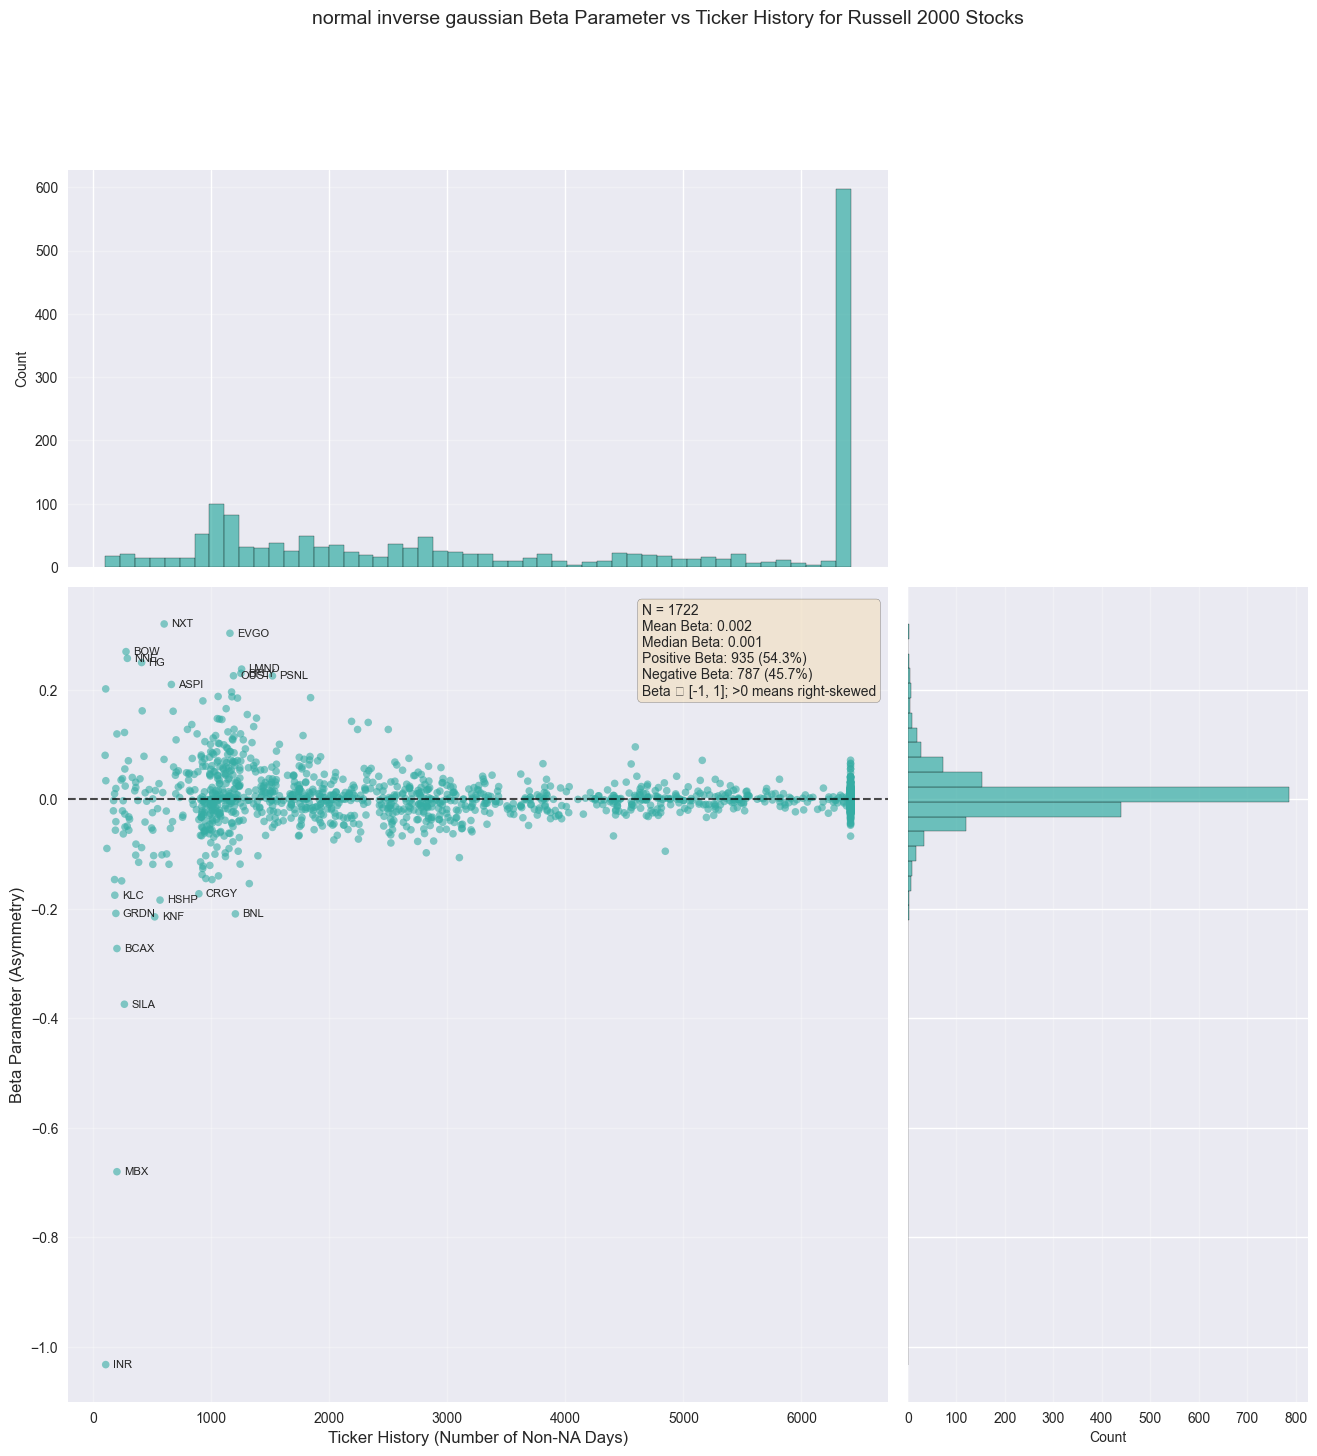

In [68]:
# Create figure with GridSpec for Beta parameter
fig = plt.figure(figsize=(16, 16))
gs = fig.add_gridspec(3, 3, hspace=0.05, wspace=0.05)

# Main scatter plot
ax_main = fig.add_subplot(gs[1:, :-1])
ax_main.scatter(results_df['ticker_history'], results_df['b'], 
                alpha=0.6, s=30, c='C3', edgecolors='none')
ax_main.set_xlabel('Ticker History (Number of Non-NA Days)', fontsize=12)
ax_main.set_ylabel('Beta Parameter (Asymmetry)', fontsize=12)
ax_main.grid(True, alpha=0.3)

# Add dashed black line at y=0
ax_main.axhline(y=0, color='black', linestyle='--', linewidth=1.5, alpha=0.7)

# Find top 10 and bottom 10 stocks by beta
top_10_beta = results_df.nlargest(10, 'b')
bottom_10_beta = results_df.nsmallest(10, 'b')

# Add ticker labels for top 10 and bottom 10
for idx, row in top_10_beta.iterrows():
    ax_main.annotate(row['ticker'], 
                     (row['ticker_history'], row['b']),
                     xytext=(5, 0), textcoords='offset points',
                     fontsize=8, ha='left', va='center')

for idx, row in bottom_10_beta.iterrows():
    ax_main.annotate(row['ticker'], 
                     (row['ticker_history'], row['b']),
                     xytext=(5, 0), textcoords='offset points',
                     fontsize=8, ha='left', va='center')

# Top histogram for ticker history
ax_hist_x = fig.add_subplot(gs[0, :-1], sharex=ax_main)
ax_hist_x.hist(results_df['ticker_history'], bins=50, alpha=0.7, color='C3', edgecolor='black')
ax_hist_x.set_ylabel('Count', fontsize=10)
ax_hist_x.tick_params(axis='x', labelbottom=False)
ax_hist_x.grid(True, alpha=0.3, axis='y')

# Right histogram for beta
ax_hist_y = fig.add_subplot(gs[1:, -1], sharey=ax_main)
ax_hist_y.hist(results_df['b'], bins=50, alpha=0.7, color='C3', 
               edgecolor='black', orientation='horizontal')
ax_hist_y.set_xlabel('Count', fontsize=10)
ax_hist_y.tick_params(axis='y', labelleft=False)
ax_hist_y.grid(True, alpha=0.3, axis='x')

# Add title
fig.suptitle('normal inverse gaussian Beta Parameter vs Ticker History for Russell 2000 Stocks', fontsize=14, y=0.98)

# Calculate positive and negative beta counts
positive_beta = (results_df['b'] > 0).sum()
negative_beta = (results_df['b'] < 0).sum()
zero_beta = (results_df['b'] == 0).sum()
total_beta = len(results_df)

# Add statistics text with positive/negative counts
stats_text = f"N = {total_beta}\n"
stats_text += f"Mean Beta: {results_df['b'].mean():.3f}\n"
stats_text += f"Median Beta: {results_df['b'].median():.3f}\n"
stats_text += f"Positive Beta: {positive_beta} ({positive_beta/total_beta*100:.1f}%)\n"
stats_text += f"Negative Beta: {negative_beta} ({negative_beta/total_beta*100:.1f}%)\n"
stats_text += f"Beta ∈ [-1, 1]; >0 means right-skewed"
ax_main.text(0.70, 0.98, stats_text, transform=ax_main.transAxes, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()


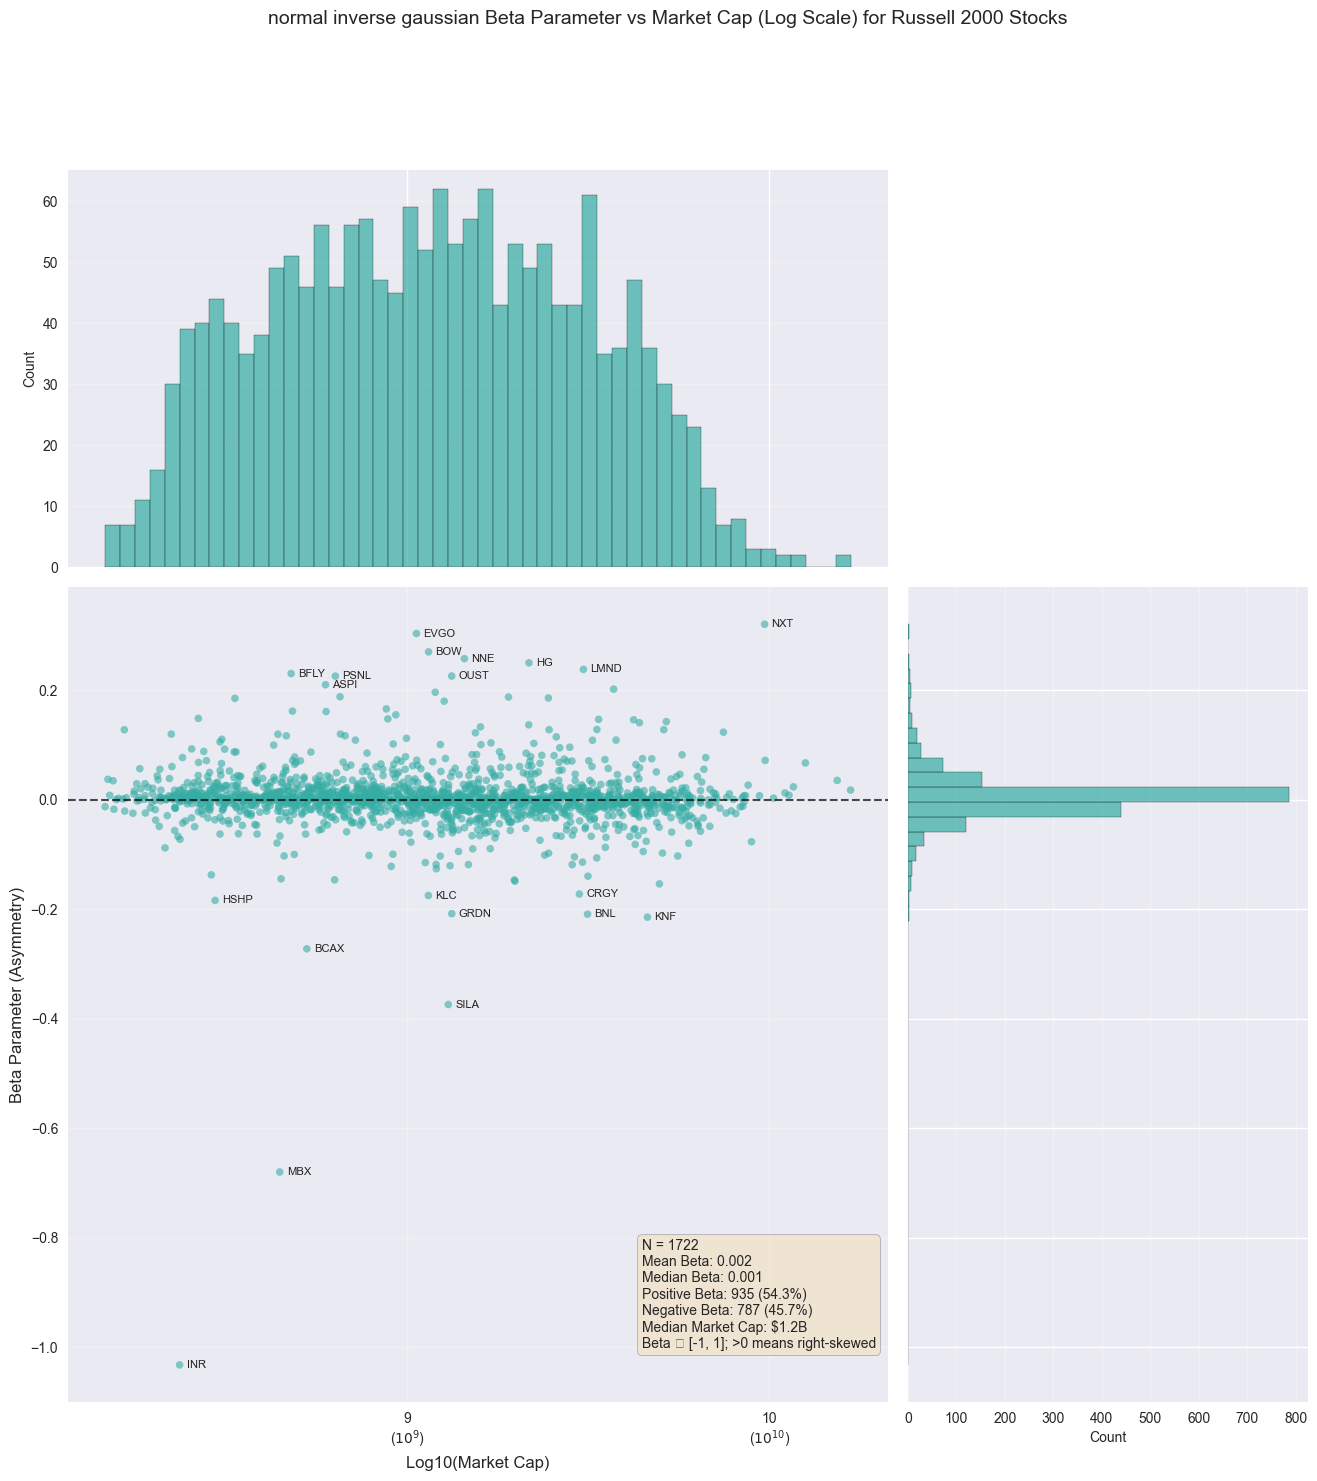

In [69]:
# Add log market cap column
results_df['log_market_cap'] = np.log10(results_df['market_cap'])

# Create figure with GridSpec for Beta parameter vs Market Cap
fig = plt.figure(figsize=(16, 16))
gs = fig.add_gridspec(3, 3, hspace=0.05, wspace=0.05)

# Main scatter plot
ax_main = fig.add_subplot(gs[1:, :-1])
ax_main.scatter(results_df['log_market_cap'], results_df['b'], 
                alpha=0.6, s=30, c='C3', edgecolors='none')
ax_main.set_xlabel('Log10(Market Cap)', fontsize=12)
ax_main.set_ylabel('Beta Parameter (Asymmetry)', fontsize=12)
ax_main.grid(True, alpha=0.3)

# Add dashed black line at y=0
ax_main.axhline(y=0, color='black', linestyle='--', linewidth=1.5, alpha=0.7)

# Find top 10 and bottom 10 stocks by beta
top_10_beta_clean = results_df.nlargest(10, 'b')
bottom_10_beta_clean = results_df.nsmallest(10, 'b')

# Add ticker labels for top 10 and bottom 10
for idx, row in top_10_beta_clean.iterrows():
    ax_main.annotate(row['ticker'], 
                     (row['log_market_cap'], row['b']),
                     xytext=(5, 0), textcoords='offset points',
                     fontsize=8, ha='left', va='center')

for idx, row in bottom_10_beta_clean.iterrows():
    ax_main.annotate(row['ticker'], 
                     (row['log_market_cap'], row['b']),
                     xytext=(5, 0), textcoords='offset points',
                     fontsize=8, ha='left', va='center')

# Format x-axis to show both log values and actual values
ax_main.set_xticks(np.arange(7, 12))
ax_main.set_xticklabels([f'{i}\n($10^{{{i}}}$)' for i in range(7, 12)])

# Top histogram for log market cap
ax_hist_x = fig.add_subplot(gs[0, :-1], sharex=ax_main)
ax_hist_x.hist(results_df['log_market_cap'], bins=50, alpha=0.7, 
               color='C3', edgecolor='black')
ax_hist_x.set_ylabel('Count', fontsize=10)
ax_hist_x.tick_params(axis='x', labelbottom=False)
ax_hist_x.grid(True, alpha=0.3, axis='y')

# Right histogram for beta
ax_hist_y = fig.add_subplot(gs[1:, -1], sharey=ax_main)
ax_hist_y.hist(results_df['b'], bins=50, alpha=0.7, color='C3', 
               edgecolor='black', orientation='horizontal')
ax_hist_y.set_xlabel('Count', fontsize=10)
ax_hist_y.tick_params(axis='y', labelleft=False)
ax_hist_y.grid(True, alpha=0.3, axis='x')

# Add title
fig.suptitle('normal inverse gaussian Beta Parameter vs Market Cap (Log Scale) for Russell 2000 Stocks', fontsize=14, y=0.98)

# Calculate positive and negative beta counts
positive_beta_clean = (results_df['b'] > 0).sum()
negative_beta_clean = (results_df['b'] < 0).sum()
zero_beta_clean = (results_df['b'] == 0).sum()
total_beta_clean = len(results_df)

# Add statistics text with positive/negative counts
stats_text = f"N = {total_beta_clean}\n"
stats_text += f"Mean Beta: {results_df['b'].mean():.3f}\n"
stats_text += f"Median Beta: {results_df['b'].median():.3f}\n"
stats_text += f"Positive Beta: {positive_beta_clean} ({positive_beta_clean/total_beta_clean*100:.1f}%)\n"
stats_text += f"Negative Beta: {negative_beta_clean} ({negative_beta_clean/total_beta_clean*100:.1f}%)\n"
stats_text += f"Median Market Cap: ${results_df['market_cap'].median()/1e9:.1f}B\n"
stats_text += f"Beta ∈ [-1, 1]; >0 means right-skewed"
ax_main.text(0.70, 0.20, stats_text, transform=ax_main.transAxes, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()


In [58]:
# Display summary statistics
print("Summary Statistics for Russell 2000 Analysis (Normal Inverse Gaussian)")
print("=" * 60)
print(f"\nTotal tickers in IWM holdings: {len(tickers)}")
print(f"Successfully processed: {len(results_df)}")
print(f"With valid market cap data: {len(results_df)}")

print("\nSkewness Statistics:")
print(f"Mean: {results_df['skewness'].mean():.4f}")
print(f"Median: {results_df['skewness'].median():.4f}")
print(f"Std Dev: {results_df['skewness'].std():.4f}")
print(f"Min: {results_df['skewness'].min():.4f}")
print(f"Max: {results_df['skewness'].max():.4f}")

print("\nTicker History Statistics:")
print(f"Mean days: {results_df['ticker_history'].mean():.0f}")
print(f"Median days: {results_df['ticker_history'].median():.0f}")
print(f"Min days: {results_df['ticker_history'].min()}")
print(f"Max days: {results_df['ticker_history'].max()}")

print("\nMarket Cap Statistics:")
print(f"Mean: ${results_df['market_cap'].mean()/1e9:.2f}B")
print(f"Median: ${results_df['market_cap'].median()/1e9:.2f}B")
print(f"Min: ${results_df['market_cap'].min()/1e6:.0f}M")
print(f"Max: ${results_df['market_cap'].max()/1e9:.2f}B")

print("\nNormal Inverse Gaussian Parameters:")
print(f"Alpha (a) - Mean: {results_df['a'].mean():.3f}, Median: {results_df['a'].median():.3f}")
print(f"Beta (b) - Mean: {results_df['b'].mean():.3f}, Median: {results_df['b'].median():.3f}")
print(f"Location - Mean: {results_df['loc'].mean():.6f}, Median: {results_df['loc'].median():.6f}")
print(f"Scale - Mean: {results_df['scale'].mean():.6f}, Median: {results_df['scale'].median():.6f}")


Summary Statistics for Russell 2000 Analysis (Normal Inverse Gaussian)

Total tickers in IWM holdings: 2051
Successfully processed: 1722
With valid market cap data: 1722

Skewness Statistics:
Mean: 0.1327
Median: 0.0266
Std Dev: 1.8711
Min: -24.6275
Max: 51.4466

Ticker History Statistics:
Mean days: 3849
Median days: 3676
Min days: 103
Max days: 6416

Market Cap Statistics:
Mean: $1.80B
Median: $1.16B
Min: $146M
Max: $16.75B

Normal Inverse Gaussian Parameters:
Alpha (a) - Mean: 0.503, Median: 0.460
Beta (b) - Mean: 0.002, Median: 0.001
Location - Mean: -0.000423, Median: 0.000075
Scale - Mean: 0.023565, Median: 0.020439


In [79]:
results_df['scale'].median()

np.float64(0.02043873218660456)

In [59]:
# Download index data
indices = ['^GSPC', '^SPXEW', '^RUT', '^R2ESC']
index_names = ['S&P 500', 'S&P 500 Equal Weight', 'Russell 2000', 'Russell 2000 Equal Weight']

# Download data since 2000
start_date = '1990-01-01'
end_date = pd.Timestamp.now().strftime('%Y-%m-%d')

# Dictionary to store index data
index_data = {}

print("Downloading index data...")
for idx, name in zip(indices, index_names):
    try:
        data = yf.download(idx, start=start_date, end=end_date, progress=False)
        if len(data) > 0:
            index_data[name] = data['Close']
            print(f"✓ Downloaded {name} ({idx}): {len(data)} days")
        else:
            print(f"✗ No data for {name} ({idx})")
    except Exception as e:
        print(f"✗ Error downloading {name} ({idx}): {str(e)}")

print(f"\nSuccessfully downloaded data for {len(index_data)} indices")


✓ Downloaded S&P 500 (^GSPC): 8944 days
✓ Downloaded S&P 500 Equal Weight (^SPXEW): 4658 days



1 Failed download:
['^R2ESC']: YFPricesMissingError('possibly delisted; no price data found  (1d 1990-01-01 -> 2025-07-09)')


✓ Downloaded Russell 2000 (^RUT): 8944 days
✗ No data for Russell 2000 Equal Weight (^R2ESC)

Successfully downloaded data for 3 indices


In [80]:
# Calculate rolling NIG parameters and skewness for each index
window = 252*2  # 2 years of trading days
rolling_nig_params = {}
rolling_skewness = {}
rolling_b_params = {}

for name, prices in index_data.items():
    print(f"\nProcessing {name}...")
    # Calculate log returns
    log_returns = np.log(prices / prices.shift(1)).dropna()
    
    # Initialize lists to store rolling parameters
    nig_params_list = []
    skewness_list = []
    b_list = []
    timestamps = []
    
    # Calculate rolling NIG parameters
    for i in tqdm(range(window, len(log_returns)), desc=f"Fitting NIG for {name}"):
        window_returns = log_returns.iloc[i-window:i].values
        
        try:
            # Fit NIG distribution to the window
            params = stats.norminvgauss.fit(window_returns, method='mle', loc=0, scale=0.02)
            a, b, loc, scale = params
            
            # Calculate skewness from NIG parameters
            # For NIG, skewness = 3 * b / (a * sqrt(a^2 - b^2))
            if a > abs(b):  # Valid parameter constraint
                skew = 3 * b / (a * np.sqrt(a**2 - b**2))
            else:
                skew = np.nan
            
            nig_params_list.append(params)
            skewness_list.append(skew)
            b_list.append(b)
            timestamps.append(log_returns.index[i])
            
        except Exception as e:
            # If fitting fails, append NaN
            nig_params_list.append((np.nan, np.nan, np.nan, np.nan))
            skewness_list.append(np.nan)
            b_list.append(np.nan)
            timestamps.append(log_returns.index[i])
    
    # Store results
    rolling_nig_params[name] = pd.DataFrame(nig_params_list, 
                                           index=timestamps,
                                           columns=['a', 'b', 'loc', 'scale'])
    rolling_skewness[name] = pd.Series(skewness_list, index=timestamps)
    rolling_b_params[name] = pd.Series(b_list, index=timestamps)
    
print(f"\nCalculated rolling NIG parameters for {len(rolling_skewness)} indices")



Processing S&P 500...


Fitting NIG for S&P 500: 100%|██████████| 8439/8439 [02:03<00:00, 68.09it/s]



Processing S&P 500 Equal Weight...


Fitting NIG for S&P 500 Equal Weight: 100%|██████████| 4153/4153 [00:56<00:00, 72.97it/s]



Processing Russell 2000...


Fitting NIG for Russell 2000: 100%|██████████| 8439/8439 [02:15<00:00, 62.16it/s]


Calculated rolling NIG parameters for 3 indices


In [73]:
rolling_b_params

{'S&P 500': 1991-12-31   -0.066066
 1992-01-02   -0.074600
 1992-01-03   -0.076532
 1992-01-06   -0.082403
 1992-01-07   -0.074119
                 ...   
 2025-07-01   -0.117944
 2025-07-02   -0.114715
 2025-07-03   -0.118042
 2025-07-07   -0.119294
 2025-07-08   -0.119424
 Length: 8439, dtype: float64,
 'S&P 500 Equal Weight': 2008-12-11   -0.047797
 2008-12-12   -0.049756
 2008-12-15   -0.050807
 2008-12-16   -0.051995
 2008-12-17   -0.046780
                 ...   
 2025-07-01   -0.094059
 2025-07-02   -0.095168
 2025-07-03   -0.098980
 2025-07-07   -0.098294
 2025-07-08   -0.095362
 Length: 4153, dtype: float64,
 'Russell 2000': 1991-12-31   -0.184431
 1992-01-02   -0.182570
 1992-01-03   -0.184444
 1992-01-06   -0.176361
 1992-01-07   -0.179510
                 ...   
 2025-07-01    0.004228
 2025-07-02    0.002387
 2025-07-03    0.002210
 2025-07-07    0.001574
 2025-07-08    0.006326
 Length: 8439, dtype: float64}

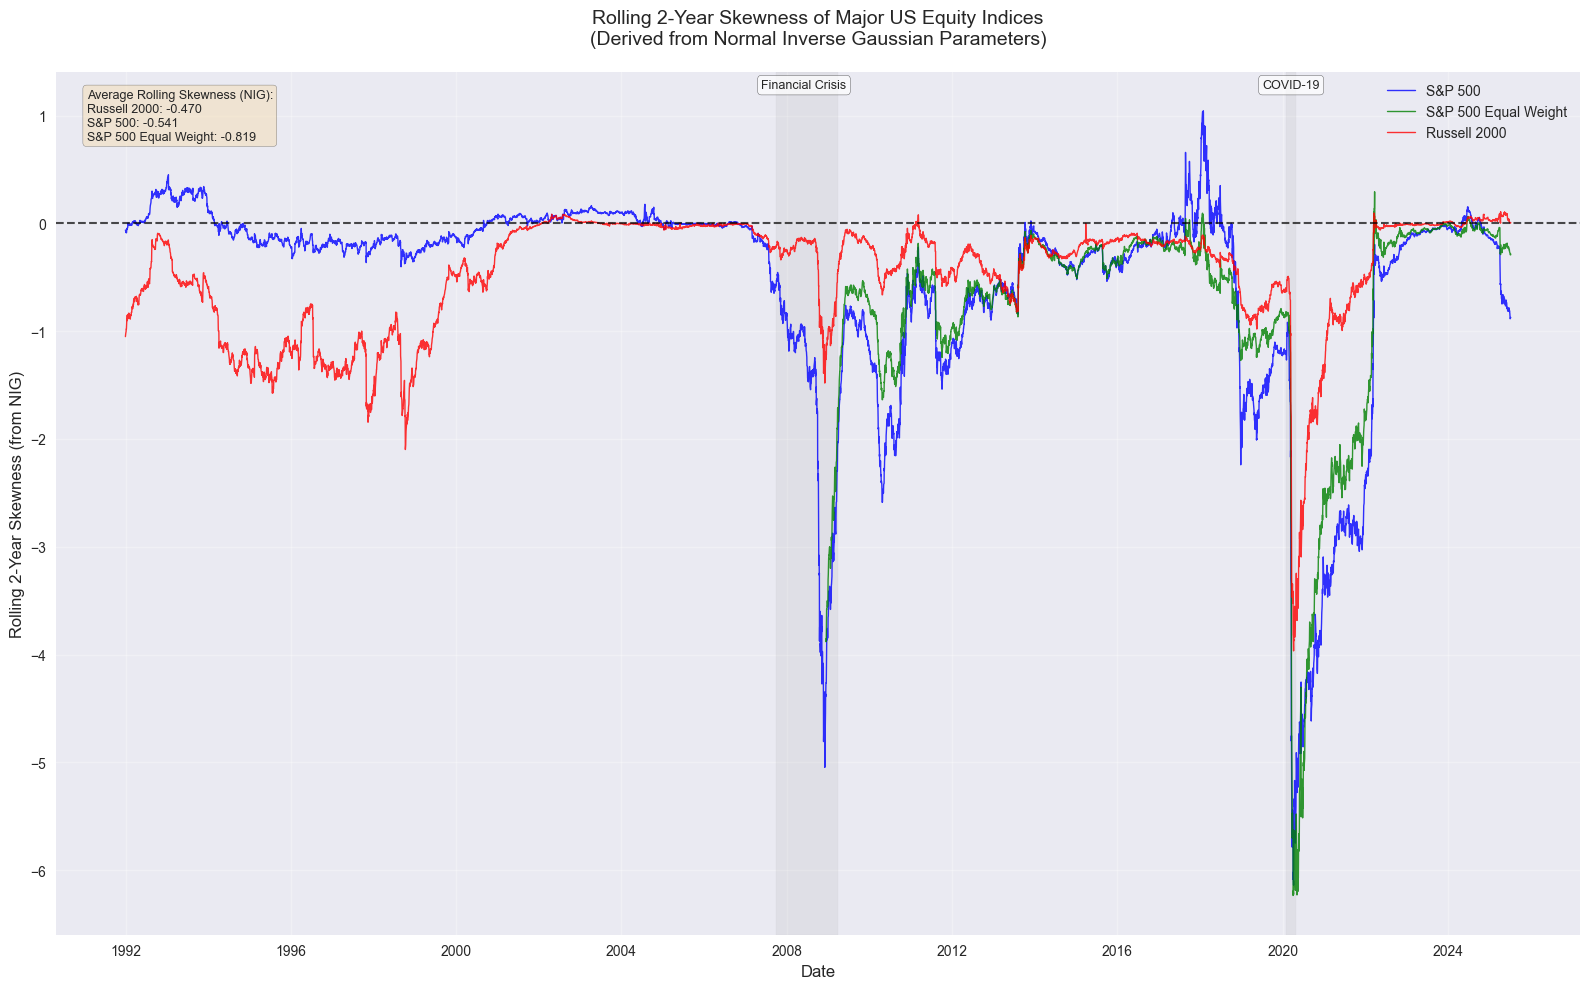


Rolling Skewness (from NIG) Summary Statistics:

S&P 500:
  Mean: -0.5407
  Median: -0.1726
  Std Dev: 0.9903
  Min: -6.1381 (on 2020-04-06)
  Max: 1.0436 (on 2018-01-29)
  Current: -0.8737

S&P 500 Equal Weight:
  Mean: -0.8191
  Median: -0.4850
  Std Dev: 1.0427
  Min: -6.2340 (on 2020-04-02)
  Max: 0.2925 (on 2022-03-23)
  Current: -0.2844

Russell 2000:
  Mean: -0.4704
  Median: -0.2620
  Std Dev: 0.5473
  Min: -3.9653 (on 2020-04-06)
  Max: 0.1075 (on 2025-04-10)
  Current: 0.0082


In [81]:
# Create rolling skewness plot (from NIG parameters)
fig, ax = plt.subplots(figsize=(16, 10))

# Define colors for each index
colors = {'S&P 500': 'blue', 
          'S&P 500 Equal Weight': 'green',
          'Russell 2000': 'red', 
          'Russell 2000 Equal Weight': 'salmon'}

# Plot each index's rolling skewness
for name, skew_series in rolling_skewness.items():
    ax.plot(skew_series.index, skew_series.values, 
            label=name, linewidth=1, alpha=0.8, color=colors.get(name, 'gray'))

# Add horizontal line at y=0
ax.axhline(y=0, color='black', linestyle='--', linewidth=1.5, alpha=0.7)

# Formatting
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Rolling 2-Year Skewness (from NIG)', fontsize=12)
ax.set_title('Rolling 2-Year Skewness of Major US Equity Indices\n(Derived from Normal Inverse Gaussian Parameters)', 
             fontsize=14, pad=20)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Add shaded regions for major market events
# Financial Crisis
ax.axvspan(pd.to_datetime('2007-10-01'), pd.to_datetime('2009-03-31'), 
           alpha=0.1, color='gray', label='Financial Crisis')
# COVID-19
ax.axvspan(pd.to_datetime('2020-02-01'), pd.to_datetime('2020-04-30'), 
           alpha=0.1, color='gray')

# Add text annotations for crisis periods
ax.text(pd.to_datetime('2008-06-01'), ax.get_ylim()[1]*0.95, 
        'Financial Crisis', fontsize=9, ha='center', va='top', 
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))
ax.text(pd.to_datetime('2020-03-15'), ax.get_ylim()[1]*0.95, 
        'COVID-19', fontsize=9, ha='center', va='top',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

# Calculate and display summary statistics
stats_text = "Average Rolling Skewness (NIG):\n"
for name in sorted(rolling_skewness.keys()):
    skew_values = rolling_skewness[name].dropna()
    mean_skew = float(skew_values.mean())
    stats_text += f"{name}: {mean_skew:.3f}\n"

ax.text(0.02, 0.98, stats_text.strip(), transform=ax.transAxes, 
        verticalalignment='top', fontsize=9,
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# Display summary statistics
print("\nRolling Skewness (from NIG) Summary Statistics:")
print("="*50)
for name, skew_series in rolling_skewness.items():
    clean_skew = skew_series.dropna()
    if len(clean_skew) > 0:
        print(f"\n{name}:")
        print(f"  Mean: {float(clean_skew.mean()):.4f}")
        print(f"  Median: {float(clean_skew.median()):.4f}")
        print(f"  Std Dev: {float(clean_skew.std()):.4f}")
        print(f"  Min: {float(clean_skew.min()):.4f} (on {clean_skew.idxmin().strftime('%Y-%m-%d')})")
        print(f"  Max: {float(clean_skew.max()):.4f} (on {clean_skew.idxmax().strftime('%Y-%m-%d')})")
        if len(clean_skew) > 0:
            print(f"  Current: {float(clean_skew.iloc[-1]):.4f}")


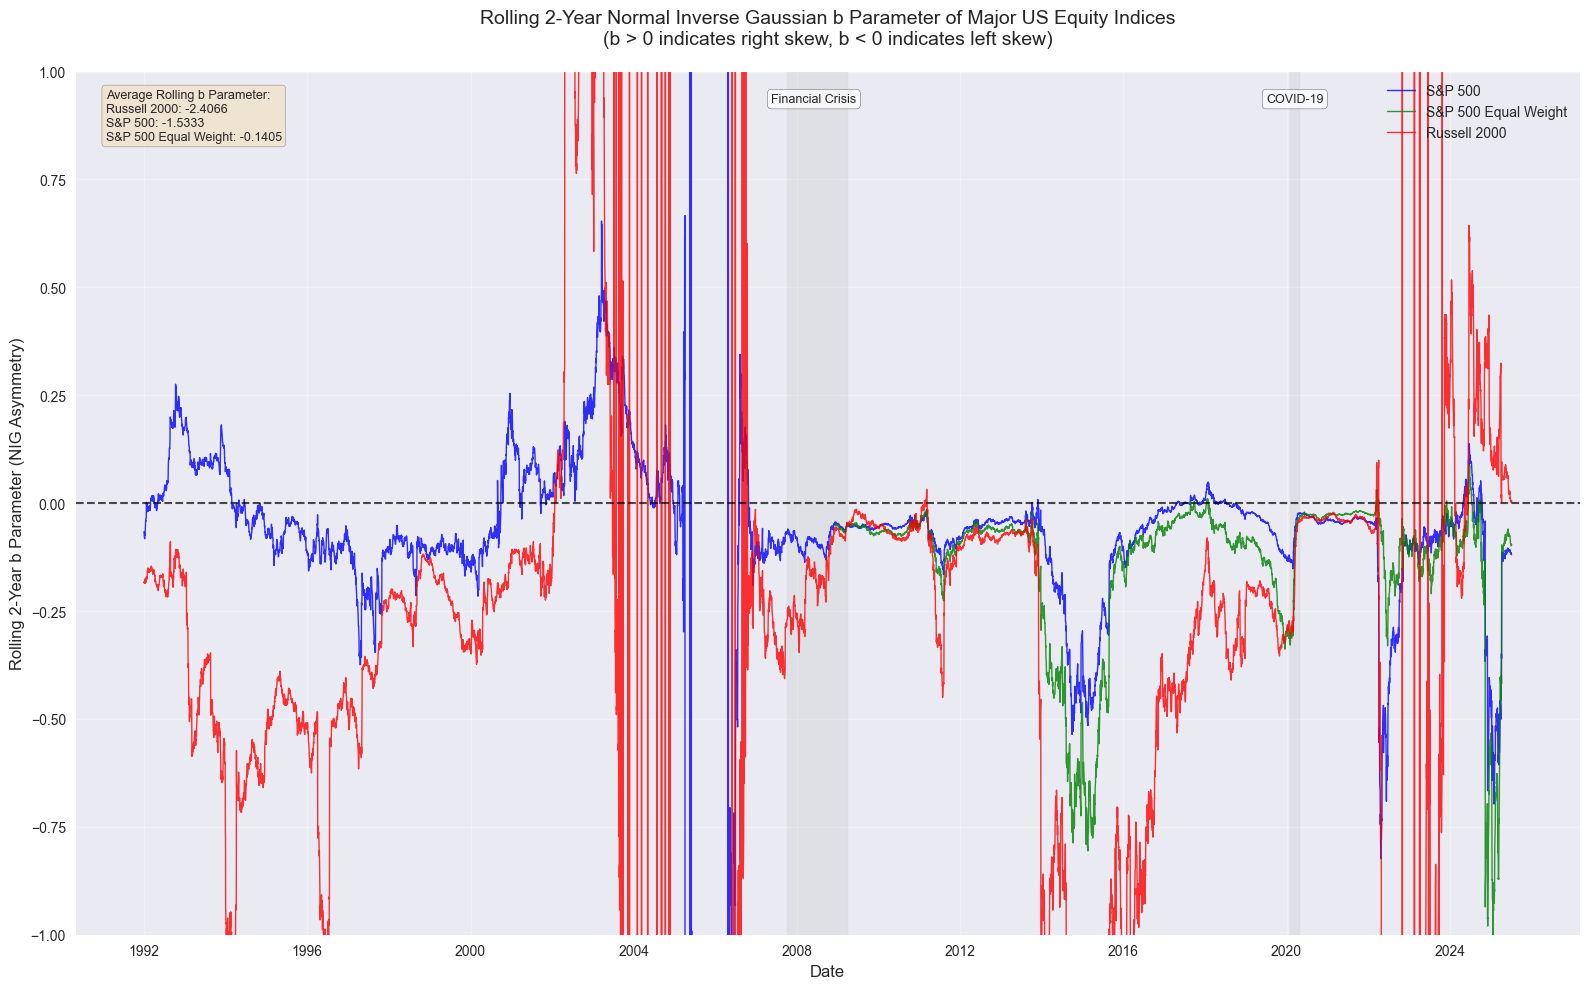


Rolling b Parameter (NIG Asymmetry) Summary Statistics:

S&P 500:
  Mean: -1.5333
  Median: -0.0535
  Std Dev: 12.3057
  Min: -396.7052 (on 2005-06-10)
  Max: 226.3683 (on 2006-04-25)
  Current: -0.1194
  % Time Right-Skewed (b > 0): 22.7%

S&P 500 Equal Weight:
  Mean: -0.1405
  Median: -0.0719
  Std Dev: 0.1788
  Min: -1.0122 (on 2025-01-22)
  Max: 0.0873 (on 2024-06-27)
  Current: -0.0954
  % Time Right-Skewed (b > 0): 1.3%

Russell 2000:
  Mean: -2.4066
  Median: -0.2465
  Std Dev: 159.6629
  Min: -592.3984 (on 2022-12-23)
  Max: 10437.3003 (on 2004-09-07)
  Current: 0.0063
  % Time Right-Skewed (b > 0): 9.0%


In [82]:
# Create rolling b parameter plot
fig, ax = plt.subplots(figsize=(16, 10))

# Plot each index's rolling b parameter
for name, b_series in rolling_b_params.items():
    ax.plot(b_series.index, b_series.values, 
            label=name, linewidth=1, alpha=0.8, color=colors.get(name, 'gray'))

# Add horizontal line at y=0
ax.axhline(y=0, color='black', linestyle='--', linewidth=1.5, alpha=0.7)

# Formatting
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Rolling 2-Year b Parameter (NIG Asymmetry)', fontsize=12)
ax.set_title('Rolling 2-Year Normal Inverse Gaussian b Parameter of Major US Equity Indices\n(b > 0 indicates right skew, b < 0 indicates left skew)', 
             fontsize=14, pad=20)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_ylim(-1, 1)

# Add shaded regions for major market events
# Financial Crisis
ax.axvspan(pd.to_datetime('2007-10-01'), pd.to_datetime('2009-03-31'), 
           alpha=0.1, color='gray', label='Financial Crisis')
# COVID-19
ax.axvspan(pd.to_datetime('2020-02-01'), pd.to_datetime('2020-04-30'), 
           alpha=0.1, color='gray')

# Add text annotations for crisis periods
ax.text(pd.to_datetime('2008-06-01'), ax.get_ylim()[1]*0.95, 
        'Financial Crisis', fontsize=9, ha='center', va='top', 
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))
ax.text(pd.to_datetime('2020-03-15'), ax.get_ylim()[1]*0.95, 
        'COVID-19', fontsize=9, ha='center', va='top',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

# Calculate and display summary statistics
stats_text = "Average Rolling b Parameter:\n"
for name in sorted(rolling_b_params.keys()):
    b_values = rolling_b_params[name].dropna()
    mean_b = float(b_values.mean())
    stats_text += f"{name}: {mean_b:.4f}\n"

ax.text(0.02, 0.98, stats_text.strip(), transform=ax.transAxes, 
        verticalalignment='top', fontsize=9,
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# Display summary statistics for b parameter
print("\nRolling b Parameter (NIG Asymmetry) Summary Statistics:")
print("="*50)
for name, b_series in rolling_b_params.items():
    clean_b = b_series.dropna()
    if len(clean_b) > 0:
        print(f"\n{name}:")
        print(f"  Mean: {float(clean_b.mean()):.4f}")
        print(f"  Median: {float(clean_b.median()):.4f}")
        print(f"  Std Dev: {float(clean_b.std()):.4f}")
        print(f"  Min: {float(clean_b.min()):.4f} (on {clean_b.idxmin().strftime('%Y-%m-%d')})")
        print(f"  Max: {float(clean_b.max()):.4f} (on {clean_b.idxmax().strftime('%Y-%m-%d')})")
        if len(clean_b) > 0:
            print(f"  Current: {float(clean_b.iloc[-1]):.4f}")
        
        # Calculate percentage of time b > 0 (right skewed)
        positive_b_pct = (clean_b > 0).sum() / len(clean_b) * 100
        print(f"  % Time Right-Skewed (b > 0): {positive_b_pct:.1f}%")
